# Exercise 3. Convolutional networks. VGG-style network.

You need to train a convolutional neural network with an architecture inspired by a VGG-network [(Simonyan \& Zisserman, 2015)](https://arxiv.org/abs/1409.1556).

In [1]:
skip_training = False  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pathlib import Path

In [4]:
# When running on your own computer, you can specify the data directory by:
data_dir = Path('./3_data/')

In [5]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## FashionMNIST dataset

Let us use the FashionMNIST dataset. It consists of 60,000 training images of 10 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform) #loading training data 
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform) #loading test data

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#We pass the Dataset as an argument to DataLoader.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True) # This wraps an iterable over our dataset, and supports automatic batching data loading.
# There are 1875 mini batches of size 32.
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=True)
# There are 2000 mini batches of size 5.

/home/leonel/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


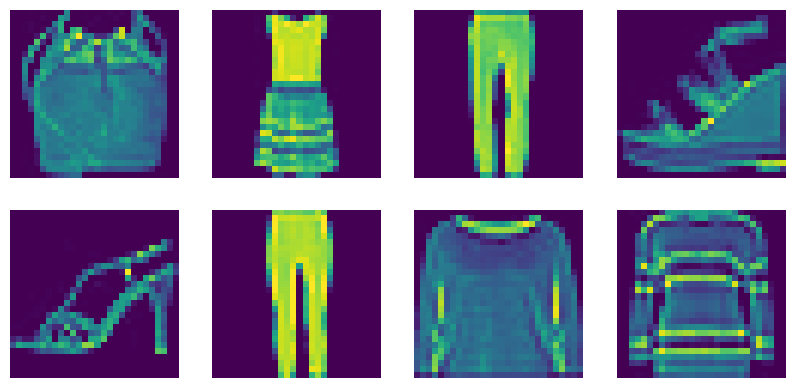

In [19]:
images, labels = next(iter(trainloader))

def plot_images(images, n_rows):
    n_cols = len(images) // n_rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    axes = axes.flatten()

    for img, ax in zip(images, axes):
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax.axis('off')
    plt.subplots_adjust(hspace=-0.65)
    plt.show()
    
plot_images(images[:8], n_rows=2)

# VGG-style network

Let us now define a convolution neural network with an architecture inspired by the [VGG-net](https://arxiv.org/abs/1409.1556).

The architecture:
- A block of three convolutional layers with:
    - 3x3 kernel
    - 20 output channels
    - one pixel zero-pading on both sides
    - 2d batch normalization after each convolutional layer
    - ReLU nonlinearity after each 2d batch normalization layer
- Max pooling layer with 2x2 kernel and stride 2.
- A block of three convolutional layers with:
    - 3x3 kernel
    - 40 output channels
    - one pixel zero-pading on both sides
    - 2d batch normalization after each convolutional layer
    - ReLU nonlinearity after each 2d batch normalization layer
- Max pooling layer with 2x2 kernel and stride 2.
- One convolutional layer with:
    - 3x3 kernel
    - 60 output channels
    - *no padding*
    - 2d batch normalization after the convolutional layer
    - ReLU nonlinearity after the 2d batch normalization layer
- One convolutional layer with:
    - 1x1 kernel
    - 40 output channels
    - *no padding*
    - 2d batch normalization after the convolutional layer
    - ReLU nonlinearity after the 2d batch normalization layer
- One convolutional layer with:
    - 1x1 kernel
    - 20 output channels
    - *no padding*
    - 2d batch normalization after the convolutional layer
    - ReLU nonlinearity after the 2d batch normalization layer
- Global average pooling (compute the average value of each channel across all the input locations):
    - 5x5 kernel (the input of the layer should be 5x5)
- A fully-connected layer with 10 outputs (no nonlinearity)

Notes:
* Batch normalization is expected to be right after a convolutional layer, before nonlinearity.
* We recommend that you check the number of modules with trainable parameters in your network.

In [8]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        
        # Block 1 - three convolutional layers
        
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(20)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(20, 20, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(20)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(20, 20, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(20)
        self.relu3 = nn.ReLU(inplace=True)
        
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 2 - three convolutional layers
        self.conv4 = nn.Conv2d(20, 40, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(40)
        self.relu4 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(40, 40, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(40)
        self.relu5 = nn.ReLU(inplace=True)
        self.conv6 = nn.Conv2d(40, 40, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(40)
        self.relu6 = nn.ReLU(inplace=True)
        
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 3 - one convolutional layer
        self.conv7 = nn.Conv2d(40, 60, kernel_size=3)
        self.bn7 = nn.BatchNorm2d(60)
        self.relu7 = nn.ReLU(inplace=True)

        # Block 4 - one convolutional layer
        self.conv8 = nn.Conv2d(60, 40, kernel_size=1)
        self.bn8 = nn.BatchNorm2d(40)
        self.relu8 = nn.ReLU(inplace=True)

        # Block 5 - one convolutional layer
        self.conv9 = nn.Conv2d(40, 20, kernel_size=1)
        self.bn9 = nn.BatchNorm2d(20)
        self.relu9 = nn.ReLU(inplace=True)
        
        # Global Average Pooling
        self.avgpool = nn.AvgPool2d(kernel_size=5)

        # Fully-connected layer
        self.fc = nn.Linear(20, 10)
        
    def forward(self, x, verbose=False):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool1(x)

        # Block 2
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.maxpool2(x)

        # Block 3
        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)
        
        # Block 4
        x = self.conv8(x)
        x = self.bn8(x)
        x = self.relu8(x)
        
        # Block 5
        x = self.conv9(x)
        x = self.bn9(x)
        x = self.relu9(x)
        
        x = self.avgpool(x)
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return(x)     

net = VGGNet()

In [9]:
def test_VGGNet_shapes():

    # Feed a batch of images from the training data to test the network
    with torch.no_grad():
        images, labels = next(iter(trainloader))
        images = images.to(device)
        print('Shape of the input tensor:', images.shape)

        y = net(images, verbose=True)
        assert y.shape == torch.Size([trainloader.batch_size, 10]), f"Bad y.shape: {y.shape}"

    print('Success')

test_VGGNet_shapes()

Shape of the input tensor: torch.Size([32, 1, 28, 28])
Success


In [10]:
# net = VGGNet()

# total_params = 0
# tab = {}
# for name, parameter in net.named_parameters():
    # if not parameter.requires_grad: continue
    # params = parameter.numel()
    # tab[name] = params
    # total_params+=params

# for n in tab:
    # print(f"Layer: {n}, n_params: {tab[n]}")

# print(f"Total Trainable Params: {total_params}")

In [11]:
def test_vgg_layers():
    net = VGGNet()
    n_conv_layers = sum(isinstance(module, nn.Conv2d) for module in net.modules())
    assert n_conv_layers == 9, f"Wrong number of convolutional layers ({n_conv_layers})"

    n_bn_layers = sum(isinstance(module, nn.BatchNorm2d) for module in net.modules())
    assert n_bn_layers == 9, f"Wrong number of batch norm layers ({n_bn_layers})"

    n_linear_layers = sum(isinstance(module, nn.Linear) for module in net.modules())
    assert n_linear_layers == 1, f"Wrong number of linear layers ({n_linear_layers})"

    print('Success')

def test_vgg_net():
    net = VGGNet()
    
    # get gradients for parameters in forward path
    net.zero_grad()
    x = torch.randn(1, 1, 28, 28)
    outputs = net(x)
    outputs[0,0].backward()
    
    parameter_shapes = sorted(tuple(p.shape) for p in net.parameters() if p.grad is not None)
    print(parameter_shapes)
    expected = [
        (10,), (10, 20), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,),
        (20,), (20,), (20,), (20, 1, 3, 3), (20, 20, 3, 3), (20, 20, 3, 3), (20, 40, 1, 1),
        (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,),
        (40, 20, 3, 3), (40, 40, 3, 3), (40, 40, 3, 3), (40, 60, 1, 1), (60,), (60,), (60,),
        (60, 40, 3, 3)]
    assert parameter_shapes == expected, "Wrong number of training parameters."
    
    print('Success')

test_vgg_layers()
test_vgg_net()

Success
[(10,), (10, 20), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20,), (20, 1, 3, 3), (20, 20, 3, 3), (20, 20, 3, 3), (20, 40, 1, 1), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40,), (40, 20, 3, 3), (40, 40, 3, 3), (40, 40, 3, 3), (40, 60, 1, 1), (60,), (60,), (60,), (60, 40, 3, 3)]
Success


# Train the network

In [12]:
# This function computes the accuracy on the test dataset
def compute_accuracy(testloader, net):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {(correct/total)*100:>0.1f}%")
    return correct / total

### Training loop

Your task is to implement the training loop. The recommended hyperparameters:
* Adam optimizer with learning rate 0.01.
* Cross-entropy loss. Note that we did not use softmax nonlinearity in the final layer of our network. Therefore, we need to use a loss function with log_softmax implemented, such as [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss).
* Number of epochs: 10

We recommend you to use function `compute_accuracy()` defined above to track the accaracy during training. The test accuracy should be above 0.89.

**Note: function `compute_accuracy()` sets the network into the evaluation mode which changes the way the batch statistics are computed in batch normalization. You need to set the network into the training mode (by calling `net.train()`) when you want to perform training.**

In [13]:
# Implement the training loop in this cell
if not skip_training:
    # YOUR CODE HERE
    CEL_loss =  nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    
    def train(dataloader, model, loss, optimizer):
        net.train()
        for batch, (images, labels) in enumerate(dataloader):

            optimizer.zero_grad()

            outputs = net(images)
            loss = CEL_loss(outputs, labels)

            loss.backward()
            optimizer.step()

            if batch%300==0:
                loss, current = loss.item(), batch+1

                print(f"Loss:{loss:>5f} [{current:>4d}/{len(trainloader)}]")
            
# train(trainloader, net, CEL_loss, optimizer) #Check the loss

In [14]:
epochs=10
for i in range(epochs):
    print(f"Epoch {i+1} \n---------------------")
    train(trainloader, net, CEL_loss, optimizer)
    compute_accuracy(testloader, net)
    
print("DONE")

Epoch 1 
---------------------
Loss:2.322326 [   1/1875]
Loss:0.298352 [ 301/1875]
Loss:0.447321 [ 601/1875]
Loss:0.475844 [ 901/1875]
Loss:0.373527 [1201/1875]
Loss:0.570009 [1501/1875]
Loss:0.236082 [1801/1875]
Accuracy: 86.6%
Epoch 2 
---------------------
Loss:0.326622 [   1/1875]
Loss:0.194315 [ 301/1875]
Loss:0.362075 [ 601/1875]
Loss:0.150867 [ 901/1875]
Loss:0.313354 [1201/1875]
Loss:0.240478 [1501/1875]
Loss:0.313609 [1801/1875]
Accuracy: 88.8%
Epoch 3 
---------------------
Loss:0.173985 [   1/1875]
Loss:0.150222 [ 301/1875]
Loss:0.176217 [ 601/1875]
Loss:0.234978 [ 901/1875]
Loss:0.235090 [1201/1875]
Loss:0.302320 [1501/1875]
Loss:0.281677 [1801/1875]
Accuracy: 90.7%
Epoch 4 
---------------------
Loss:0.136782 [   1/1875]
Loss:0.126740 [ 301/1875]
Loss:0.201591 [ 601/1875]
Loss:0.355940 [ 901/1875]
Loss:0.496545 [1201/1875]
Loss:0.205371 [1501/1875]
Loss:0.084960 [1801/1875]
Accuracy: 91.2%
Epoch 5 
---------------------
Loss:0.314658 [   1/1875]
Loss:0.060336 [ 301/1875]
L

In [16]:
if not skip_training:
    torch.save(net.state_dict(), '3_vgg_net.pth')

In [17]:
if skip_training:
    net = LeNet5()
    model.load_state_dict(torch.load('2_lenet5.pth'))

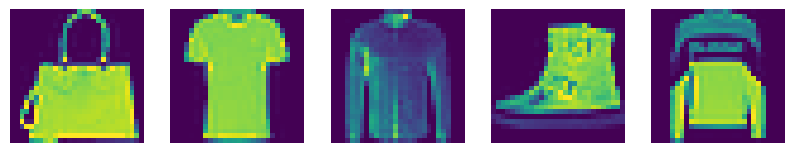

Ground truth labels:         Bag T-shirt/top      Shirt Ankle boot   Pullover
Predictions:                 Bag T-shirt/top      Shirt Ankle boot   Pullover


In [21]:
# Display random images from the test set, the ground truth labels and the network's predictions
net.eval()
with torch.no_grad():
    images, labels = next(iter(testloader))
    plot_images(images[:5], n_rows=1)
    # Compute predictions
    images = images.to(device)
    y = net(images)

print('Ground truth labels: ', ' '.join('%10s' % classes[labels[j]] for j in range(5)))
print('Predictions:         ', ' '.join('%10s' % classes[j] for j in y.argmax(dim=1)))

In [22]:
# Compute the accuracy on the test set
accuracy = compute_accuracy(testloader, net)
print('Accuracy of the network on the test images: %.3f' % accuracy)
assert accuracy > 0.85, "Poor accuracy {:.3f}".format(accuracy)
print('Success')

Accuracy: 92.3%
Accuracy of the network on the test images: 0.923
Success
